In [ ]:
!pip install -q kaggle
!pip install -q --upgrade --force-reinstall --no-deps kaggle
from google.colab import files
files.upload() #upload your kaggle.json file
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ashishjangra27/doodle-dataset
!unzip -q doodle-dataset.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ashishjangra27/doodle-dataset
License(s): CC0-1.0
100% 4.71G/4.72G [00:54<00:00, 227MB/s]
100% 4.72G/4.72G [00:54<00:00, 92.4MB/s]


In [ ]:
import os
import cv2
import json
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt

In [ ]:
# Data parameters
IMG_WIDTH, IMG_HEIGHT = 64, 64

# Function to convert drawing data to an image
def json_to_image(drawing):
    drawing_data = json.loads(drawing)
    image = np.zeros((256, 256), dtype=np.uint8)
    for stroke in drawing_data:
        for i in range(len(stroke[0]) - 1):
            cv2.line(image, (stroke[0][i], stroke[1][i]), (stroke[0][i+1], stroke[1][i+1]), 255, 2)
    return image


In [ ]:

# Load dataset
df = pd.read_csv('/content/master_doodle_dataframe.csv')


In [ ]:
# --- Autoencoder Model ---
def create_autoencoder_model():
    input_img = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1))

     # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = UpSampling2D((2, 2))(encoded)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [ ]:
# --- Data Generator for Autoencoder ---
def autoencoder_data_generator(csv_file, batch_size):
    df = pd.read_csv(csv_file)
    while True:
        X = []
        for index, row in df.iterrows():
            image = json_to_image(row['drawing'])
            image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
            X.append(image)
            if len(X) >= batch_size:
                yield np.array(X).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1) / 255.0, np.array(X).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1) / 255.0
                X = []
        if X:
            yield np.array(X).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1) / 255.0, np.array(X).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1) / 255.0


In [ ]:
# --- Training ---
autoencoder = create_autoencoder_model()
batch_size = 64
epochs = 10

autoencoder.fit(
    autoencoder_data_generator('/content/master_doodle_dataframe.csv', batch_size),
    steps_per_epoch=len(df) // batch_size,
    epochs=epochs
)


Epoch 1/10
 8568/15937 ━━━━━━━━━━━━━━━━━━━━ 7:10 58ms/step - loss: 0.0389

In [ ]:
# Save the autoencoder model
autoencoder.save('doodle_autoencoder_model.h5')

In [ ]:
# --- Visualization ---
def visualize_reconstruction(original, reconstructed):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(original.squeeze(), cmap='gray')
    axes[0].set_title('Original')
    axes[1].imshow(reconstructed.squeeze(), cmap='gray')
    axes[1].set_title('Reconstructed')
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  


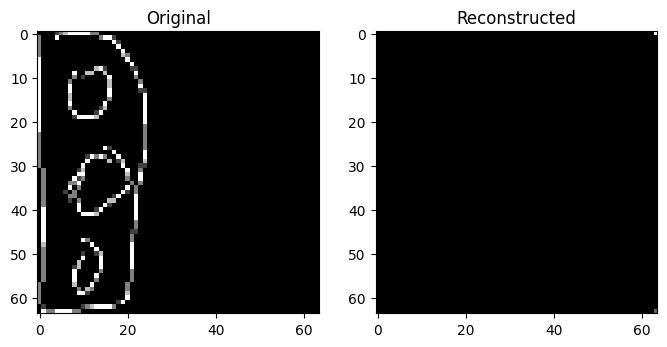

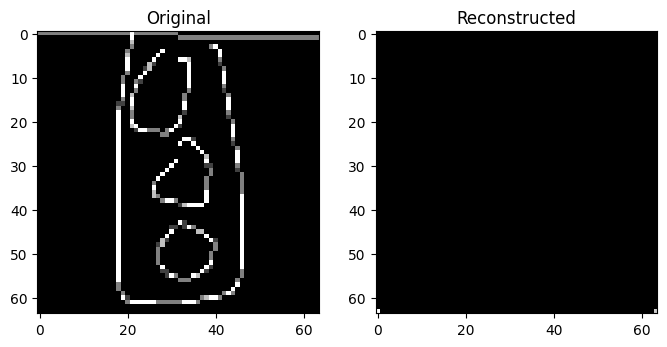

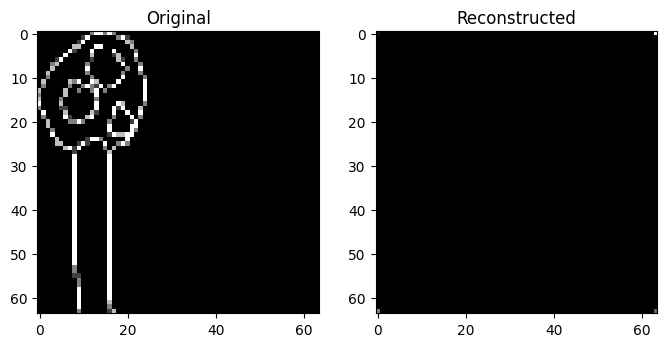

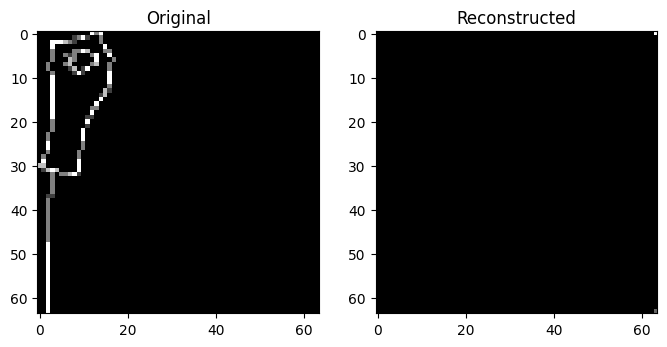

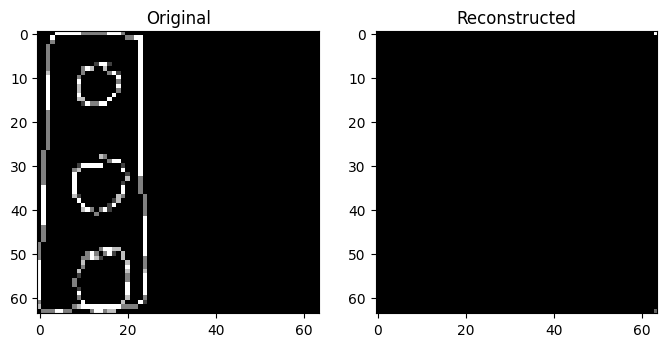

In [ ]:
# Load some test data
test_data_generator = autoencoder_data_generator('/content/master_doodle_dataframe.csv', batch_size)
X_test_batch, _ = next(test_data_generator)

# Make predictions
reconstructed_images = autoencoder.predict(X_test_batch)

# Visualize some examples
for i in range(5):
    visualize_reconstruction(X_test_batch[i], reconstructed_images[i])

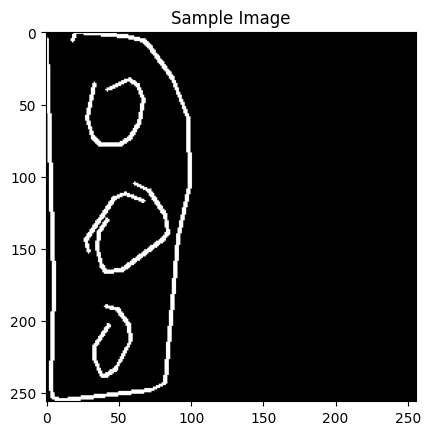

In [ ]:
#additional cells for testing
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to convert drawing data to an image
def json_to_image(drawing):
    drawing_data = json.loads(drawing)
    image = np.zeros((256, 256), dtype=np.uint8)
    for stroke in drawing_data:
        for i in range(len(stroke[0]) - 1):
            cv2.line(image, (stroke[0][i], stroke[1][i]), (stroke[0][i+1], stroke[1][i+1]), 255, 2)
    return image

# Load and visualize a sample image from the dataset
import pandas as pd
df = pd.read_csv('/content/master_doodle_dataframe.csv')
sample_drawing = df['drawing'].iloc[0]
sample_image = json_to_image(sample_drawing)

plt.imshow(sample_image, cmap='gray')
plt.title('Sample Image')
plt.show()


Batch shape: (64, 64, 64, 1)


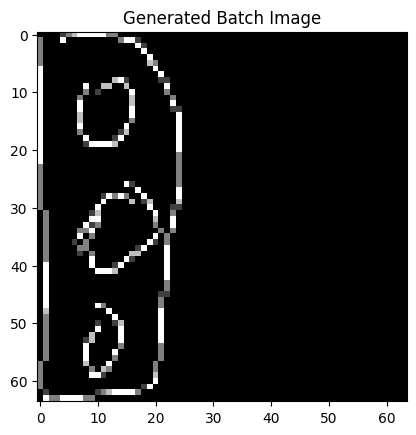

In [ ]:
def autoencoder_data_generator(csv_file, batch_size):
    df = pd.read_csv(csv_file)
    while True:
        X = []
        for index, row in df.iterrows():
            image = json_to_image(row['drawing'])
            image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
            X.append(image)
            if len(X) >= batch_size:
                yield np.array(X).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1) / 255.0, np.array(X).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1) / 255.0
                X = []
        if X:
            yield np.array(X).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1) / 255.0, np.array(X).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1) / 255.0

# Test the data generator
batch_size = 64
generator = autoencoder_data_generator('/content/master_doodle_dataframe.csv', batch_size)
X_batch, _ = next(generator)

print(f"Batch shape: {X_batch.shape}")
plt.imshow(X_batch[0].squeeze(), cmap='gray')
plt.title('Generated Batch Image')
plt.show()


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

def create_autoencoder_model():
    input_img = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = UpSampling2D((2, 2))(encoded)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

autoencoder = create_autoencoder_model()
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,321 (220.00 KB)

 Trainable params: 56,321 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


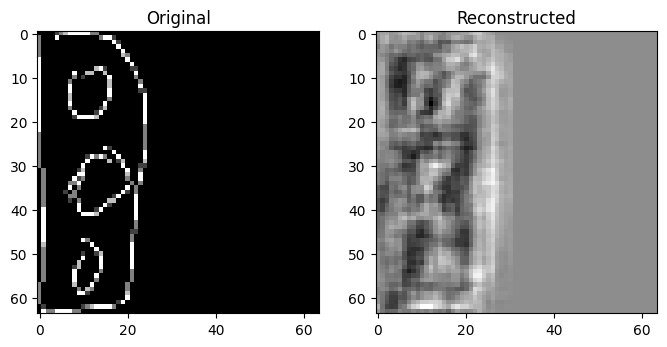

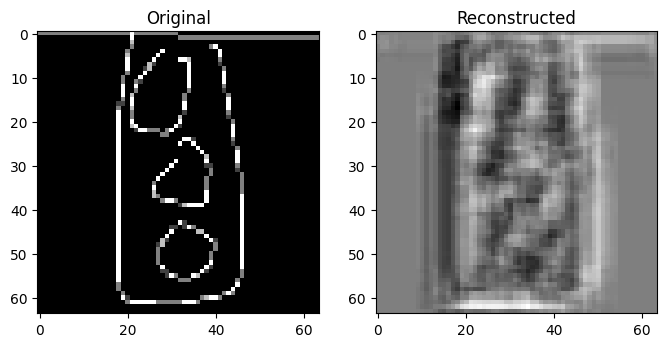

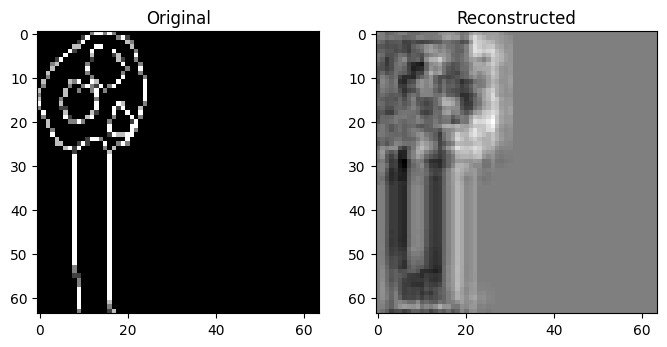

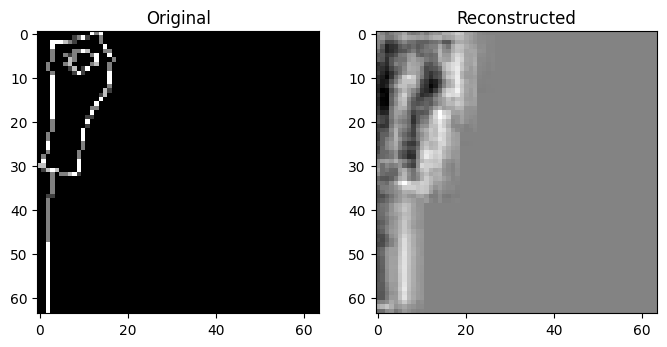

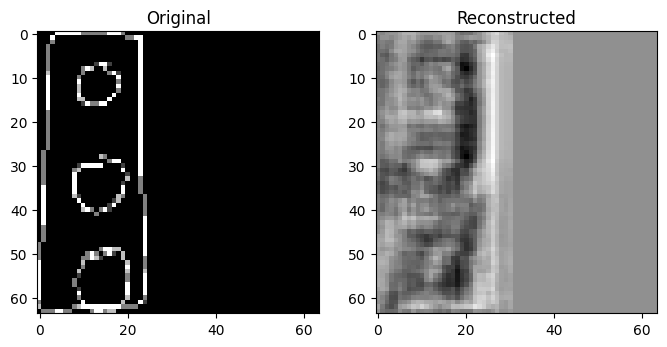

In [ ]:
def visualize_reconstruction(original, reconstructed):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(original.squeeze(), cmap='gray')
    axes[0].set_title('Original')
    axes[1].imshow(reconstructed.squeeze(), cmap='gray')
    axes[1].set_title('Reconstructed')
    plt.show()

# Load some test data
test_data_generator = autoencoder_data_generator('/content/master_doodle_dataframe.csv', batch_size)
X_test_batch, _ = next(test_data_generator)

# Make predictions
reconstructed_images = autoencoder.predict(X_test_batch)

# Visualize some examples
for i in range(5):
    visualize_reconstruction(X_test_batch[i], reconstructed_images[i])


In [ ]:
def autoencoder_data_generator(csv_file, batch_size):
    df = pd.read_csv(csv_file)
    while True:
        X = []
        for index, row in df.iterrows():
            image = json_to_image(row['drawing'])
            image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
            X.append(image)
            if len(X) >= batch_size:
                yield np.array(X).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1) / 255.0, np.array(X).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1) / 255.0
                X = []
        if X:
            yield np.array(X).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1) / 255.0, np.array(X).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1) / 255.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


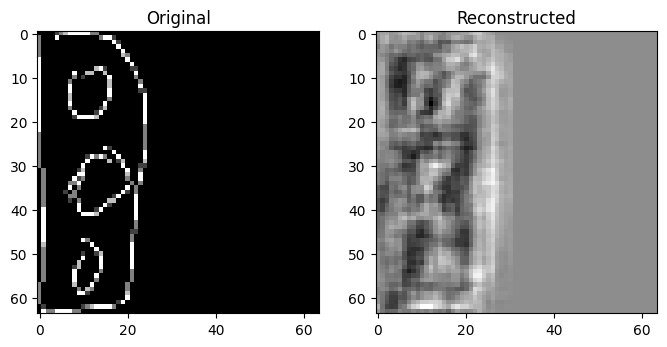

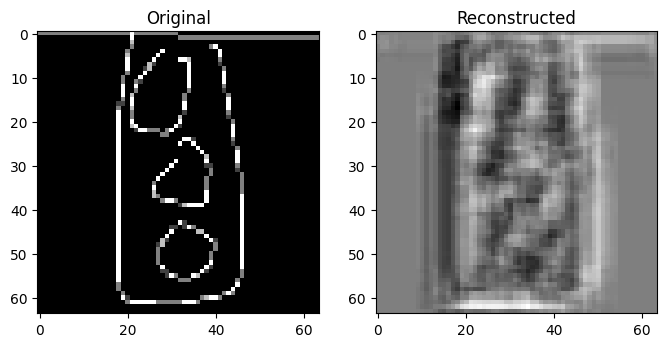

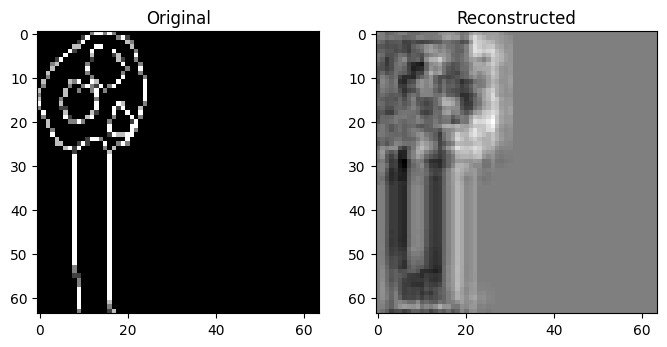

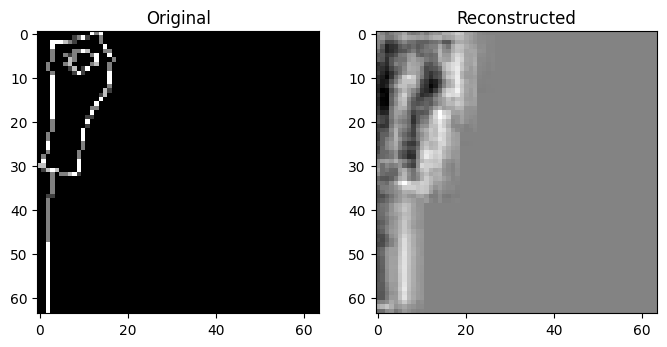

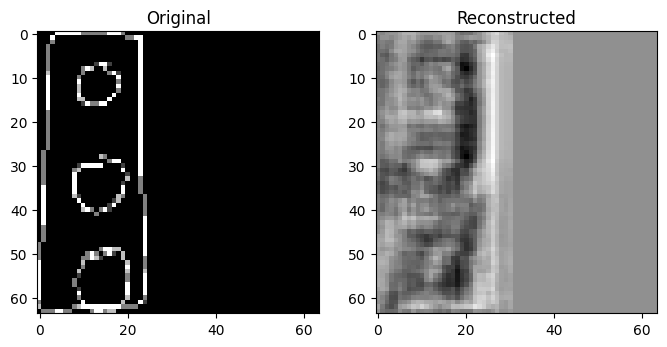

In [ ]:
def visualize_reconstruction(original, reconstructed):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(original.squeeze(), cmap='gray')
    axes[0].set_title('Original')
    axes[1].imshow(reconstructed.squeeze(), cmap='gray')
    axes[1].set_title('Reconstructed')
    plt.show()

# Load some test data
test_data_generator = autoencoder_data_generator('/content/master_doodle_dataframe.csv', batch_size)
X_test_batch, _ = next(test_data_generator)

# Make predictions
reconstructed_images = autoencoder.predict(X_test_batch)

# Visualize some examples
for i in range(5):
    visualize_reconstruction(X_test_batch[i], reconstructed_images[i])
